## Setup

In [93]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile

from sklearn.preprocessing import OneHotEncoder

In [94]:
with zipfile.ZipFile("cook_county_data.zip", mode="r") as archive:
    archive.printdir()

File Name                                             Modified             Size
cook_county_contest_test.csv                   2023-12-28 16:04:04     26243187
cook_county_train.csv                          2023-12-28 16:04:06     98564494
cook_county_train_val.csv                      2023-12-28 16:04:06     98564494


In [95]:
with zipfile.ZipFile("cook_county_data.zip", mode="r") as item:
    with item.open("cook_county_train_val.csv") as csv:
        training_val_data = pd.read_csv(csv, index_col='Unnamed: 0')

We define all helper functions in the following block:

In [96]:
def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    train = data.iloc[shuffled_indices[:163833], :]
    validation = data.iloc[shuffled_indices[163833:], :]
    
    return train, validation


def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def plot_distribution(data, column, ybot=None, ytop=None):
    plt.hist(data[column], bins=100, density=True)
    plt.title('Distribution of ' + column)
    plt.xlabel(column)
    plt.ylabel('Density')
    if ybot is not None:
        plt.ylim(bottom=ybot)
    if ytop is not None:
        plt.ylim(top=ytop)
    plt.show()


def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
        data (DataFrame): the table to be filtered
        variable (string): the column with numerical outliers
        lower (numeric): observations with values lower than or equal to this will be removed
        upper (numeric): observations with values higher than this will be removed
    
    Output:
        a DataFrame with outliers removed
    
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] <= upper) & (data[variable] > lower)]


def add_rooms(data):
    """
    Input:
        data (DataFrame): a DataFrame containing at least the Description column.

    Output:
        a Dataframe with new columns "Bedrooms", "Bathrooms", and "Total Rooms" containing ints and floats.

    """
    with_rooms = data.copy()
    pat_bed = r"rooms, (\d+) of which are bedrooms"
    pat_bath = r", and (\d+.\d) of which are bathrooms" 
    pat_total = r"It has a total of (\d+) rooms"
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(pat_bed).astype(int)
    with_rooms['Bathrooms'] = with_rooms['Description'].str.extract(pat_bath).astype(float)
    with_rooms['Total Rooms'] = with_rooms['Description'].str.extract(pat_total).astype(int)
    
    return with_rooms


def log_transform(data, column):
    new_data = data.copy()
    new_data['Log ' + column] = np.log(data[column] + 0.0001)
    
    return new_data


def ohe_col(data, columns):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    ohe = OneHotEncoder(drop='first', sparse=False)
    ohe_arr = ohe.fit_transform(data.loc[:, columns])
    ohe_columns = ohe.get_feature_names_out(columns)
    ohe_df = pd.DataFrame(ohe_arr, columns=ohe_columns, index=data.index)
    
    return pd.concat([data, ohe_df], axis=1), ohe_columns


def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    groupby = data[['Neighborhood Code', 'Sale Price']].groupby('Neighborhood Code').agg(metric)
    groupby = groupby.sort_values(by = 'Sale Price', ascending= False)
    neighborhoods = groupby.head(n).index
    
    return [int(code) for code in neighborhoods]


def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype(int)
    
    return data
    
    
def impute_data(data, column, imputed_value, upper=np.inf, lower=-np.inf):
    new_data = data.copy()
    new_data.loc[(new_data[column] >= upper) | (new_data[column] <= lower), column] = imputed_value
    
    return new_data

## EDA

We begin our analysis by splitting our data for cross-validation and taking a look at the list of features we have to work with.

In [97]:
train, valid = train_val_split(training_val_data)

In [98]:
train.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

Since we would like to model the `Sale Price` of any given property, it's a good idea to first gain an understanding of its distribution before trying any further analytical work.

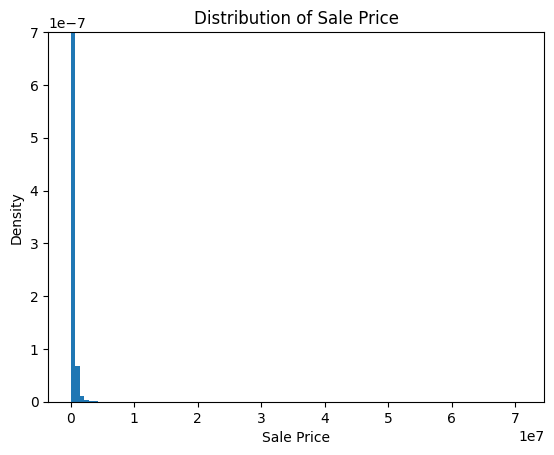

In [99]:
plot_distribution(train, 'Sale Price', ytop=7e-7)

In [100]:
train['Sale Price'].describe()

count    1.638330e+05
mean     2.454202e+05
std      3.725118e+05
min      1.000000e+00
25%      4.590000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

As we can see, there is a heavy right-skew to `Sale Price`, meaning that a transformation of some sort is necessary to normalize it somewhat. In particular, a log transformation should give us more to work with. We can also see some odd outliers on both the high end low ends of the distribution, which we should remove in order to make both our modeling and visualization tasks more accurate and comprehendable.

In [101]:
train = remove_outliers(train, "Sale Price", lower=700)
train = log_transform(train, 'Sale Price')

In [102]:
train['Sale Price'].describe()

count    1.351940e+05
mean     2.974087e+05
std      3.907670e+05
min      7.500000e+02
25%      1.207500e+05
50%      2.150000e+05
75%      3.500000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

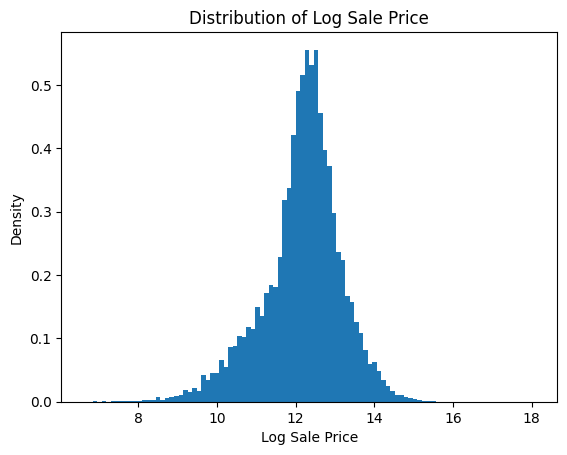

In [103]:
plot_distribution(train, 'Log Sale Price')

The `Log Sale Price` data is much more usable, and thus we will use it for our modeling before applying exponentiation to the model at the end of the process.

We can now begin to analyze how each feature in the dataset relates to `Log Sale Price` in order to get a better understanding of which ones are worth including in our model. We start by focusing on continuous quantitative features, such as `Building Square Feet`.

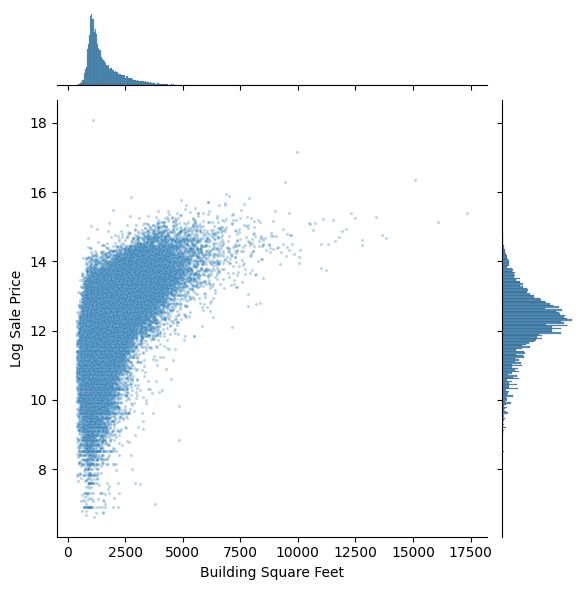

In [104]:
sns.jointplot(train, x='Building Square Feet', y='Log Sale Price', alpha=0.3, joint_kws={'s':5})

There seems to be a nonlinear trend for which we could transform `Building Square Feet` with a logarithm to linearize.

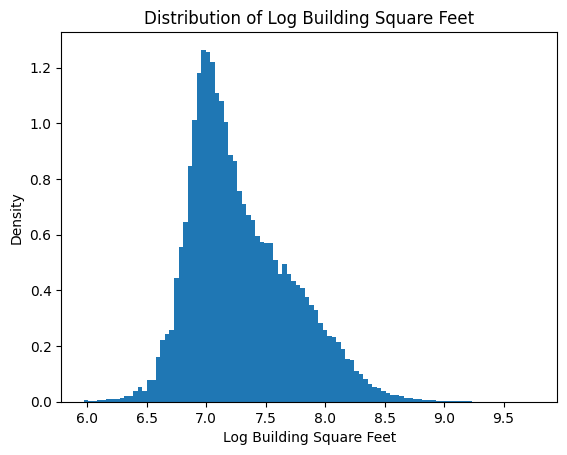

In [105]:
train = log_transform(train, 'Building Square Feet')
plot_distribution(train, 'Log Building Square Feet')

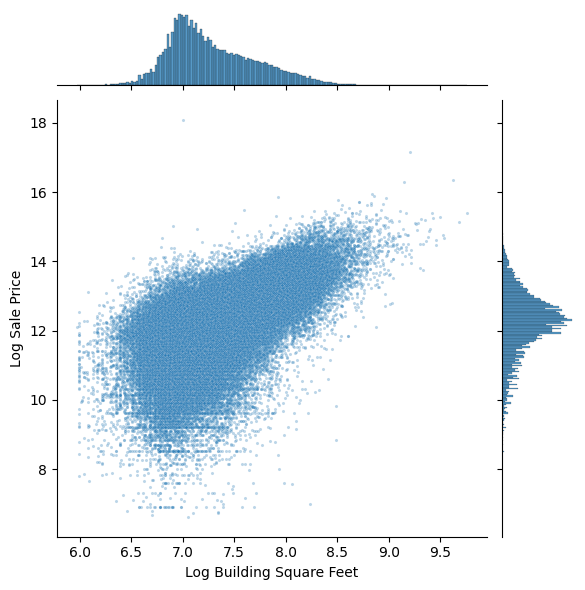

In [106]:
sns.jointplot(train, x='Log Building Square Feet', y='Log Sale Price', alpha=0.3, joint_kws={'s':5})

There is now a very apparent linear relationship between `Log Sale Price` and `Log Building Square Feet`, with statistics as follows:

In [107]:
train['Log Sale Price'].corr(train['Log Building Square Feet'])

0.5922742546551614

The correlation coefficient for the two is relatively high, and thus we will use `Log Building Square Feet` as a feature in our model.

We follow a similar pattern as above, exploring continuous numerical features while performing transformations and removing outliers as needed:

Text(0.5, 0, 'Log Estimate (Land)')

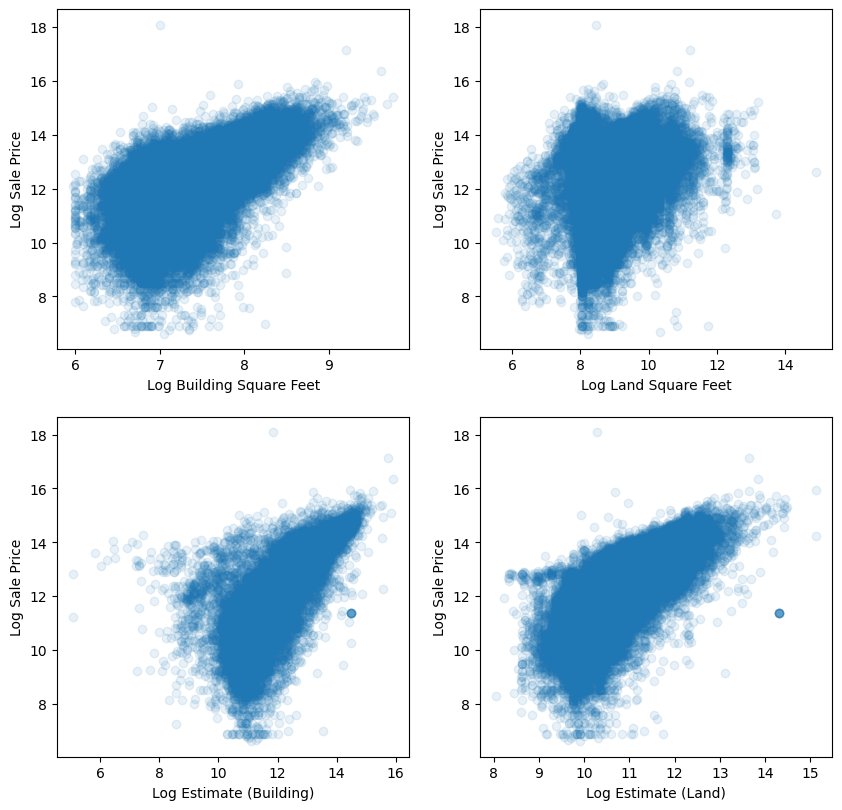

In [108]:
#Apply log tranformation to features which need it, determined after visualizing intitial distributions against 'Log Sale Price'
train = log_transform(train, 'Land Square Feet')
train = log_transform(train, 'Estimate (Building)')
train = log_transform(train, 'Estimate (Land)')

#Remove outliers where applicable
train = remove_outliers(train, 'Estimate (Building)', lower=1)
train = remove_outliers(train, 'Estimate (Building)', lower=1)
#Impute with mean where applicable


plt.figure(figsize=(10, 15))
plt.subplot(3, 2, 1)
plt.scatter(train['Log Building Square Feet'], train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Building Square Feet")

plt.subplot(3, 2, 2)
plt.scatter(train['Log Land Square Feet'], train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Land Square Feet")

plt.subplot(3, 2, 3)
plt.scatter(train['Log Estimate (Building)'], train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Estimate (Building)")

plt.subplot(3, 2, 4)
plt.scatter(train['Log Estimate (Land)'], train["Log Sale Price"], alpha=0.1)
plt.ylabel("Log Sale Price")
plt.xlabel("Log Estimate (Land)")

In [109]:
print("Correlation of Log Sale Price with Log Building Square Feet: " + str(train['Log Sale Price'].corr(train['Log Building Square Feet'])))
print("Correlation of Log Sale Price with Log Land Square Feet: " + str(train['Log Sale Price'].corr(train['Log Land Square Feet'])))
print("Correlation of Log Sale Price with Log Estimate (Building): " + str(train['Log Sale Price'].corr(train['Log Estimate (Building)'])))
print("Correlation of Log Sale Price with Log Estimate (Land): " + str(train['Log Sale Price'].corr(train['Log Estimate (Land)'])))

print("Correlation of Log Land Square Feet with Log Building Square Feet: " + str(train['Log Building Square Feet'].corr(train['Log Land Square Feet'])))
print("Correlation of Log Estimate (Land) with Log Estimate (Building): " + str(train['Log Building Square Feet'].corr(train['Log Land Square Feet'])))

Correlation of Log Sale Price with Log Building Square Feet: 0.5881778047038594
Correlation of Log Sale Price with Log Land Square Feet: 0.2710688830879861
Correlation of Log Sale Price with Log Estimate (Building): 0.7859721295722233
Correlation of Log Sale Price with Log Estimate (Land): 0.7040893125355194
Correlation of Log Land Square Feet with Log Building Square Feet: 0.45837886631132835
Correlation of Log Estimate (Land) with Log Estimate (Building): 0.45837886631132835


As we can see, the features `Log Building Square Feet`, `Log Estimate (Building)`, and `Log Estimate (Land)` all have strong linear relationships with `Log Sale Price`. That said, `Log Estimate (Land)` and `Log Estimate (Building)` also have a rather high correlation, so using them together may lead to multicollinearity.

We now begin to explore the effects of categorical features on `Log Sale Price`.

<Axes: xlabel='Fireplaces', ylabel='Log Sale Price'>

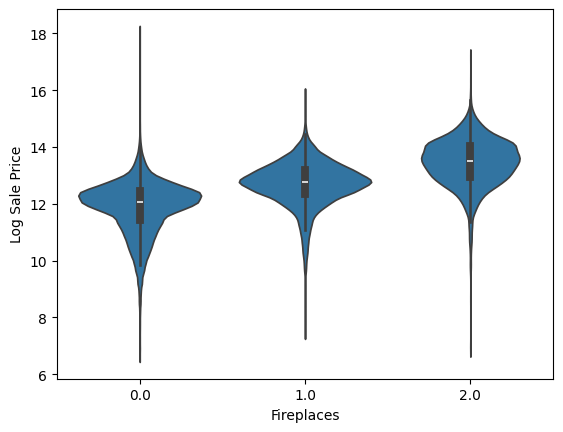

In [110]:
sns.violinplot(train, x='Fireplaces', y='Log Sale Price')

<Axes: xlabel='Central Air', ylabel='Log Sale Price'>

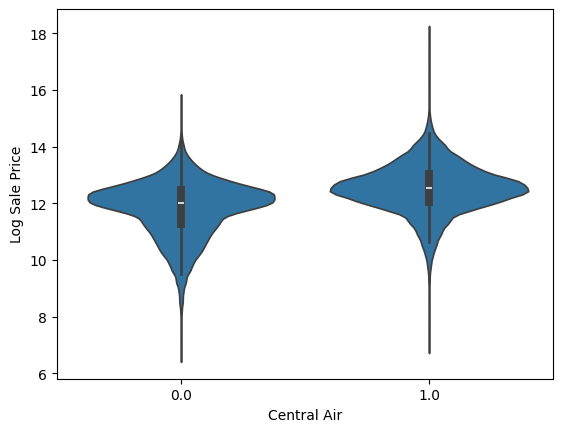

In [111]:
sns.violinplot(train, x="Central Air", y='Log Sale Price')

There is already a strong linear relation between these features, so `Fireplaces` and `Central Air` are worth using in modeling.

<Axes: xlabel='Property Class', ylabel='Log Sale Price'>

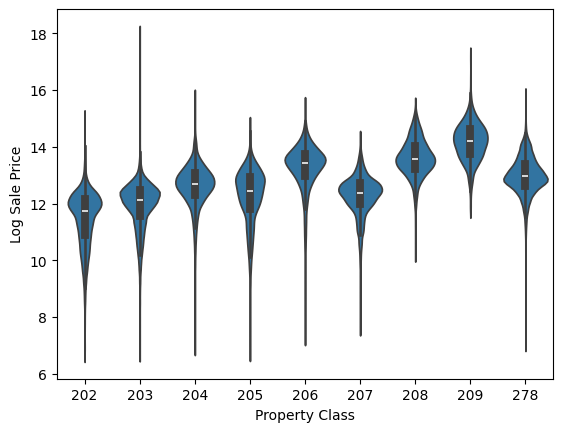

In [112]:
sns.violinplot(train, x='Property Class', y='Log Sale Price')

<Axes: xlabel='Town Code', ylabel='Log Sale Price'>

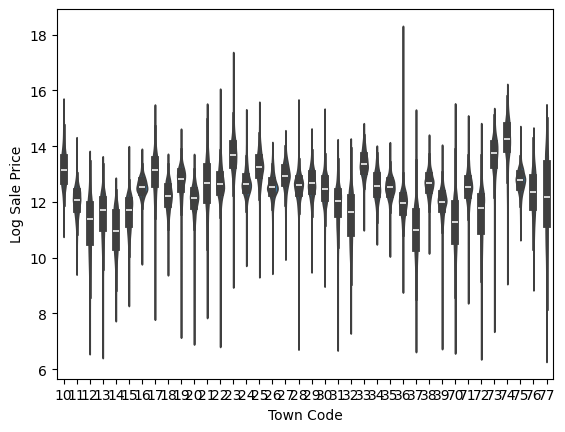

In [113]:
sns.violinplot(data=train, x = 'Town Code', y = 'Log Sale Price')

As before, both `Town Code` and `Property Class` seem to have a relationship we could utilize, so they will be used in our model.

We now look at some discrete quantitative data in the form of the number of rooms in the property, including the number of which are bedrooms or bathrooms specifically. We utilize a helper function defined earlier to extract this information from the `Description` column of our training dataset.

In [114]:
train = add_rooms(train)
train = remove_outliers(train, 'Bathrooms', upper=15)

<Axes: xlabel='Bathrooms', ylabel='Log Sale Price'>

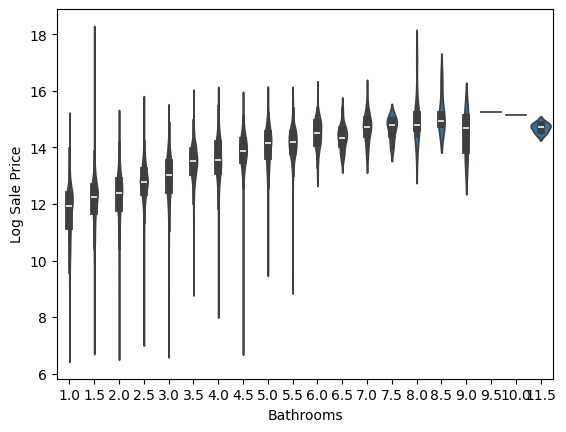

In [115]:
sns.violinplot(data=train, x = 'Bathrooms', y = 'Log Sale Price')

<Axes: xlabel='Bedrooms', ylabel='Log Sale Price'>

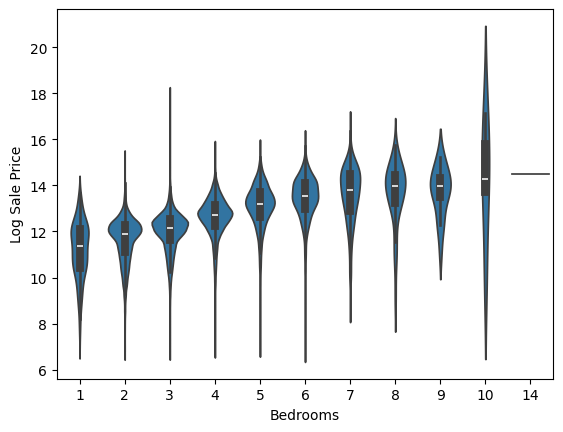

In [116]:
sns.violinplot(data=train, x = 'Bedrooms', y = 'Log Sale Price')

<Axes: xlabel='Total Rooms', ylabel='Log Sale Price'>

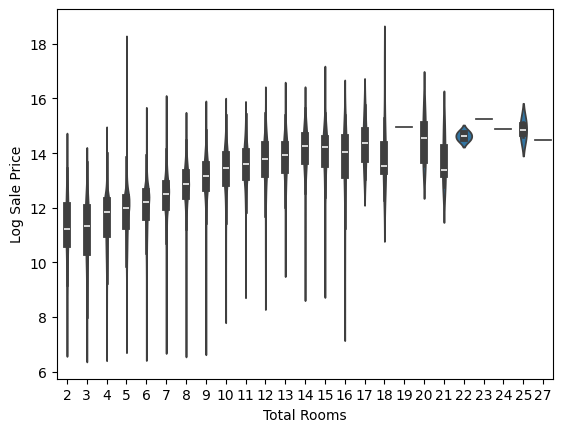

In [117]:
sns.violinplot(data=train, x = 'Total Rooms', y = 'Log Sale Price')

## Data Pipeline

In [118]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def process_data_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data = remove_outliers(data, 'Sale Price', lower=np.percentile(data['Sale Price'], 1), upper=np.percentile(data['Sale Price'], 97))    
        data['Log Sale Price'] = np.log(data['Sale Price'])
        
        data = add_rooms(data)
        data = remove_outliers(data, 'Bathrooms', upper=np.percentile(data['Bathrooms'], 97))
        
        #data = remove_outliers(data, 'Estimate (Building)', lower=np.percentile(data['Estimate (Building)'], 1), upper=np.percentile(data['Estimate (Building)'], 97))
        
        data = impute_data(data, 'Estimate (Building)', np.mean(data['Estimate (Building)']))
        
        data = impute_data(data, 'Estimate (Land)', np.mean(data['Estimate (Land)']))

    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data = add_rooms(data)
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    data = log_transform(data, 'Building Square Feet')
        
    data = log_transform(data, 'Estimate (Building)')
    
    data = log_transform(data, 'Land Square Feet')
        
    data = log_transform(data, 'Estimate (Land)')
    
    data, ohe_columns = ohe_col(data, ['Repair Condition', 'Fireplaces', 'Central Air', 'Town Code'])# 'Property Class', 'Town Code'])
    
    
    expensive_neighborhoods = find_expensive_neighborhoods(data, 10, np.median)
    data = add_in_expensive_neighborhood(data, expensive_neighborhoods)
    
    cols = ['Log Building Square Feet', 'Log Estimate (Building)', 'Bathrooms', 'in_expensive_neighborhood', 'Log Land Square Feet', 'Log Estimate (Land)'] + ohe_columns.tolist()
    #cols = ['Log Building Square Feet', 'Log Estimate (Building)', 'Bathrooms', 'Repair Condition_1.0', 'Repair Condition_2.0', 'Repair Condition_3.0', 'in_expensive_neighborhood']
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = data.loc[:, cols]
        X = X.fillna(0)
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0)) + 0.00001
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = data.loc[:, cols]
        X = X.fillna(0)
        X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0)) + 0.00001
        # Response variable
        Y = data['Log Sale Price']
        
        return X, Y

## Model Evaluation

In [119]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again
def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len) 
    train_indices = shuffled_indices[:int(data_len * 0.8)] 
    validation_indices = shuffled_indices[int(data_len * 0.8):] 
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
    return train, validation
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

with zipfile.ZipFile("cook_county_data.zip", 'r') as item:
    with item.open("cook_county_train_val.csv") as csv:
        data = pd.read_csv(csv, index_col='Unnamed: 0')
train, validation = train_val_split(data)
final_model = lm.LinearRegression(fit_intercept=True)
trainX, trainy = process_data_final(train)
validationX = process_data_final(validation, is_test_set=True) 

print(str(trainX.shape[1]) + " number of features are used")

# depending on random split some ohe columns might be missing
missing = set(trainX.columns) - set(validationX.columns) 
for m in missing:
    validationX[m] = 0
missing = set(validationX.columns) - set(trainX.columns) 
for m in missing:
    trainX[m] = 0
    
final_model.fit(trainX, trainy)

y_fitted = final_model.predict(trainX)
y_predicted = final_model.predict(validationX)
training_error_delog = rmse(np.exp(y_fitted), np.exp(trainy)) 
validation_error_delog = rmse(np.exp(y_predicted), validation["Sale Price"]) 
print(" Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_delog, validation_error_delog))

48 number of features are used
 Model 
Training RMSE: 107807.52016570157
Validation RMSE: 251604.47005797515

